In [1]:
import argparse
import numpy as np
from matplotlib import pyplot
from matplotlib.pyplot import figure
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.ticker import MaxNLocator

In [2]:
bd1 = 40
bd2 = 160
latency = 200
oracles = {}

In [3]:
def ipToNode(ip):
    return (int(ip, 16)-int('0b000001', 16))/int('00000100', 16)


# i,j are hex ip, size is in bytes
def oracle(i, j, size):
    data_transmission_delay = 0
    data_propagation_delay = 0
    header_transmission_delay = 0
    header_propagation_delay = 0
    size = int(size)
    oversubscription_ratio = 1
    hdr_size = 64
    mss = 1000
    if ipToNode(i)/16 == ipToNode(j)/16:
        header_transmission_delay = 2.0 * 8.0 * ((hdr_size) / bd1);
        header_propagation_delay = 2.0 * latency;
        data_transmission_delay = ((size / mss) * 8.0 * (mss + hdr_size) / (bd1)) + (8.0 * (mss + hdr_size) / bd1);
        data_propagation_delay = 2.0 * latency;
    else:
        header_transmission_delay = (2.0 * (8.0 * (hdr_size) / bd1)) + (2.0 * 8.0 * ((hdr_size) / (4 * bd1/oversubscription_ratio)))
        header_propagation_delay = 4.0 * latency
        data_transmission_delay = ((size / mss) * 8.0 * (mss + hdr_size) / (bd1)) + (8.0 * (mss + hdr_size) / bd1) + (2.0 * 8.0*(mss + hdr_size) / (4*bd1/oversubscription_ratio))
        data_propagation_delay = 4.0 * latency

    return data_propagation_delay + data_transmission_delay + header_transmission_delay + header_propagation_delay

In [62]:
oracle('0b000101','0b006401',5000)

3015.2

In [4]:
def slowdown(f,dx):
    slowdowns = []
    with open(f, 'r') as f:
        for line in f.readlines():
            tokens = line.split()
            slowdowns.append(
                int(tokens[6])/oracle(tokens[0], tokens[1], tokens[4]))
    slowdowns = np.array(slowdowns)
    slowdowns.sort()
    s = 0
    i = 0
    dx = 0.001
    X = np.arange(1, 100, dx)
    Y = []
    for s in X:
        while i < len(slowdowns) and slowdowns[i] < s:
            i += 1
        Y.append(i)
    Y = np.array(Y)
    Y = Y/len(slowdowns)
    return slowdowns,Y

In [5]:
ccs = ['hpcc','timely','dcqcn','dctcp']

In [6]:
def cdf(experiment, dx=0.001):
    slowdowns = []
    cdfs = []
    for cc in ccs:
        result = slowdown("../experiments/{0}/{1}/fct.txt".format(experiment,cc), dx)
        slowdowns.append(result[0])
        cdfs.append(result[1])
    for i in range(len(ccs)):
        mean = np.mean(slowdowns[i])
        median = np.median(slowdowns[i])
        nn = slowdowns[i][int(len(slowdowns[i])*.99)]
        print("{0}: mean: {1}, median: {2}, 99%: {3}".format(ccs[i],mean,median,nn))
        X = np.arange(1, 100, dx)
    for cdf in cdfs:
        pyplot.plot(X, cdf)
    pyplot.xscale('log')
    pyplot.legend(ccs, loc='lower right')
    pyplot.xlabel('log slowdown')
    pyplot.ylabel('cdf')
    pyplot.show()

In [7]:
def slowdownBySize(f):
    slowdowns = {}
    with open(f, 'r') as f:
        for line in f.readlines():
            tokens = line.split()
            size = int(tokens[4])
            if size not in slowdowns:
                slowdowns[size] = []
            slowdowns[int(tokens[4])].append(int(tokens[6])/oracle(tokens[0], tokens[1], tokens[4]))
    slowdownsm = {}
    for size in slowdowns:
        slowdownsm[size] = np.mean(slowdowns[size])
    lists = sorted(slowdownsm.items())
    return lists

In [48]:
def sdvssize(experiment,ytick,xtick,sigma):
    slowdowns = []
    for cc in ccs:
        result = slowdownBySize("../experiments/{0}/{1}/fct.txt".format(experiment,cc))
        slowdowns.append(result)
    for slowdown in slowdowns:
        x, y = zip(*slowdown)
        pyplot.plot(x,gaussian_filter1d(y, sigma=sigma))
    pyplot.xscale('log')
    pyplot.yscale('log')
    pyplot.legend(ccs, loc='upper left')
    pyplot.xlabel('flow size')
    pyplot.ylabel('log slowdown')
    pyplot.xticks(xtick[0],xtick[1])
    pyplot.yticks(np.arange(ytick[0],ytick[1]),np.arange(ytick[0],ytick[1]).astype(int))
    pyplot.show()

hpcc: mean: 3.784977299105103, median: 2.9955026938179166, 99%: 16.991028216601226
timely: mean: 2.590669000433752, median: 2.2856360149758013, 99%: 6.848233038078715
dcqcn: mean: 2.5548918110218244, median: 2.2555017806593005, 99%: 6.7376267007579225
dctcp: mean: 2.7983055639895897, median: 2.503310199981737, 99%: 7.032006209478587


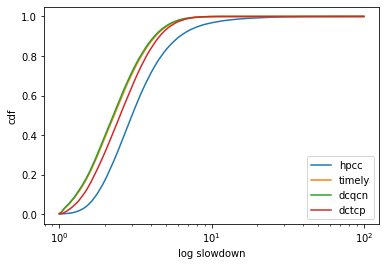

In [9]:
cdf('rpc_32')

hpcc: mean: 2.7118343916080727, median: 2.17114875353849, 99%: 10.435348370011871
timely: mean: 1.9990784710300429, median: 1.667770066660579, 99%: 5.949913249931513
dcqcn: mean: 1.9762945807460508, median: 1.6508766322710255, 99%: 5.855287188384623
dctcp: mean: 2.0335407104374035, median: 1.7166240525979364, 99%: 5.8637339055794


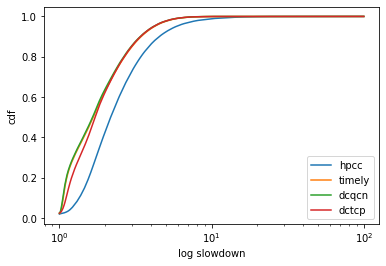

In [9]:
cdf('rpc_32_a1')

hpcc: mean: 5.5895973421363605, median: 3.8663104351847095, 99%: 28.851025021836307
timely: mean: 2.7619778075707746, median: 2.4206186096696296, 99%: 7.509762112726713
dcqcn: mean: 2.7216466947541496, median: 2.3880568257719776, 99%: 7.386643888403638
dctcp: mean: 3.099024635654832, median: 2.7641550634537326, 99%: 7.959589991265478


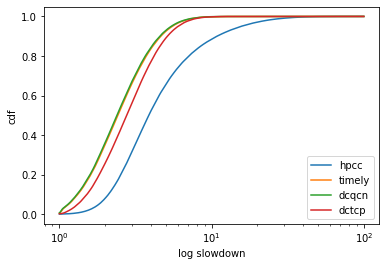

In [14]:
cdf('rpc_64')

hpcc: mean: 7.36463907515005, median: 4.802481020637487, 99%: 35.888124537506506
timely: mean: 2.9560490033779154, median: 2.5084961767204756, 99%: 8.433654452270671
dcqcn: mean: 2.837517992949544, median: 2.474237399621783, 99%: 7.8728382711650715
dctcp: mean: 3.307049646792008, median: 2.9529352920218157, 99%: 8.533895634061446


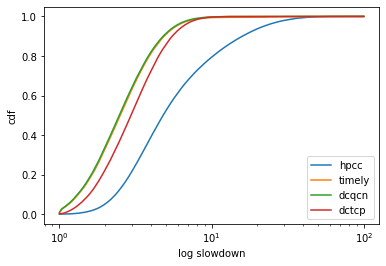

In [53]:
cdf('rpc_128')

hpcc: mean: 3.948401201639716, median: 2.832632885627226, 99%: 17.915713031336814
timely: mean: 5.666766434814459, median: 3.375722769182685, 99%: 32.04634802400165
dcqcn: mean: 4.45598228707803, median: 3.012907746963775, 99%: 24.716532174632732
dctcp: mean: 3.208958797622562, median: 2.7924774443100118, 99%: 8.941648337430456


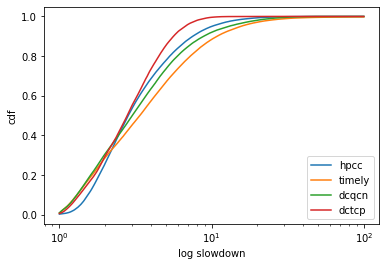

In [10]:
cdf('dctcp')

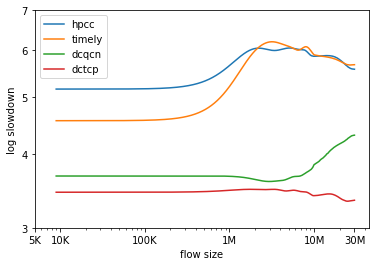

In [49]:
xtick = (np.array([5000,10000,100000,1000000,10000000,30000000]), ('5K', '10K', '100K', '1M','10M','30M'))
sdvssize('dctcp',(3,8),xtick,500)

hpcc: mean: 4.233257651158287, median: 2.5012877940070077, 99%: 25.715845086875568
timely: mean: 3.2729194024243404, median: 2.1257680464940494, 99%: 15.401924270639354
dcqcn: mean: 3.1388863858146006, median: 2.0553396703175197, 99%: 15.248034347196358
dctcp: mean: 2.2896596767053823, median: 1.8880617743705752, 99%: 7.263703260536918


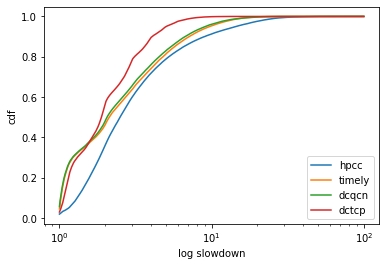

In [46]:
cdf('dctcp_a1')

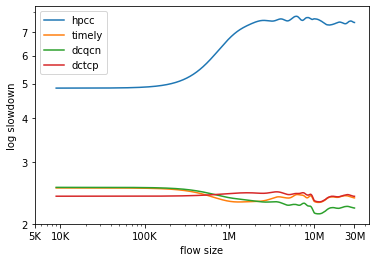

In [56]:
xtick = (np.array([5000,10000,100000,1000000,10000000,30000000]), ('5K', '10K', '100K', '1M','10M','30M'))
sdvssize('dctcp_a1',(2,8),xtick,300)

hpcc: mean: 2.3648832335247696, median: 1.3909426987060998, 99%: 15.451522206791385
timely: mean: 9.38586721078516, median: 2.8732514987153865, 99%: 73.14787430683919
dcqcn: mean: 8.74191077276445, median: 2.905013688424374, 99%: 61.53373382624769
dctcp: mean: 2.7771379876482922, median: 2.050369685767098, 99%: 9.8137707948244


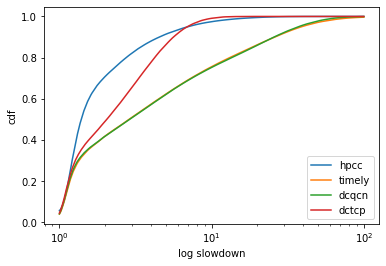

In [11]:
cdf('facebook')

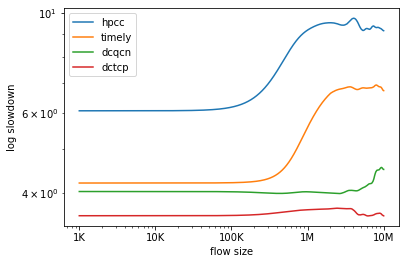

In [18]:
sdvssize('facebook',10000000,300)